In [1]:
import os
import sys

ROOT_DIR = os.path.abspath("__file__" + "/../../")
sys.path.insert(0, f"{ROOT_DIR}")

In [2]:
import numpy as np

spin_j = 6

env_name = f"single vertex spinfoam/j={float(spin_j)}"
batch_size = 16
n_iterations = int(1e5)

vertex = np.load(f"{ROOT_DIR}/data/EPRL_vertices/Python/Dl_20/vertex_j_{float(spin_j)}.npz")
sq_ampl = vertex**2
grid_rewards = sq_ampl / np.sum(sq_ampl)

# Generate Data

In [3]:
from src.MCMC.batched_mcmc import MCMCRunner

mcmc = MCMCRunner(grid_rewards=grid_rewards)
mcmc_chains, _ = mcmc.run_mcmc_chains(
    batch_size=batch_size, n_iterations=n_iterations, generated_data_dir=f"{ROOT_DIR}/data/MCMC/{env_name}"
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:37<00:00, 2700.11it/s]


In [4]:
from src.grid_environments.base import BaseGrid
from src.trainers.trainer import train_gfn

loss_params = {
    "weighing": "geometric_within",
    "lamda": 0.9,
}
replay_params = {
    "capacity": 1000,
    "fraction_of_samples_from_top": 0.5,
    "top_and_bottom_fraction": 0.1,
    "max_fraction_offline": 0.5,
}
nn_params = {
    "hidden_dim": 256,
    "n_hidden_layers": 2,
    "activation_fn": "relu",
}

device_str = "cpu" # cpu or cuda (torchgfn has some issues with gpu)

terminal_states, _ = train_gfn(
    env=BaseGrid(grid_rewards=grid_rewards, device_str=device_str),
    generated_data_dir=f"{ROOT_DIR}/data/GFN/{env_name}", # need better way to label folders
    batch_size=batch_size,
    n_iterations=n_iterations,
    learning_rate=0.001,
    exploration_rate=0.0, # (faster if set to 0)
    policy="ssr",
    forward_looking=True,
    loss_params=loss_params,
    replay_params=None, # replay_params or None (faster if None)
    nn_params=nn_params,
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [3:16:31<00:00,  8.48it/s]


# Analyze

In [5]:
import glob
import matplotlib.pyplot as plt

def get_distributions_over_time(grid_positions, grid_len, every_n_iterations=100):
    n_iterations, _, grid_dim = grid_positions.shape

    counts = np.zeros(shape=(grid_len, )*grid_dim)
    n_samples = 0
    empirical_distributions_over_time = []
    n_samples_used_over_time = []
    for i in range(0, n_iterations, every_n_iterations):
        states = np.concatenate(grid_positions[i:i+every_n_iterations])

        n_samples += states.shape[0]
        np.add.at(counts, tuple(states.T), 1)
        
        empirical_distributions_over_time.append(counts/n_samples)
        n_samples_used_over_time.append(n_samples)
    empirical_distributions_over_time = np.stack(empirical_distributions_over_time)
    return empirical_distributions_over_time, n_samples_used_over_time

def plot_l1_errors(
    empirical_distributions_over_time, expected_distribution, n_samples_used, ax, label
):
    l1_errors = np.abs(empirical_distributions_over_time - expected_distribution)
    
    grid_axes = empirical_distributions_over_time.ndim
    ave_error_over_time = np.mean(l1_errors, axis=tuple(range(1, grid_axes)))
    ax.scatter(n_samples_used, ave_error_over_time, label=label)
    ax.set_xlabel("n_samples in distribution")
    ax.set_ylabel(r"Average Distribution Error")
    ax.legend()
    

def plot_observable_expectation_values(
    empirical_distributions, n_samples_used, spin_j, ax, label
):
    intertwiners = np.arange(int(2*spin_j + 1))
    cos_angle = intertwiners*(intertwiners+1)/(2*spin_j*(spin_j+1)) - 1

    reduced_distr_over_t = np.sum(empirical_distributions, axis=(2, 3, 4, 5))
    mean_cos_angles = np.sum(reduced_distr_over_t*cos_angle, axis=1)

    ax.scatter(n_samples_used, mean_cos_angles, label=label)
    ax.hlines(-0.33333, n_samples_used[0], n_samples_used[-1], colors='k', linestyles='dashed')
    ax.set_xlabel("n_samples in distribution")
    ax.set_ylabel(r"<cos $\theta$>")
    ax.legend()

def get_n_steps_from_grid_origin(expected):
    assert len(set(expected.shape)) == 1
    
    grid_len = expected.shape[0]
    grid_dim = expected.ndim
    n_steps_from_origin = sum(np.meshgrid(*[np.arange(grid_len)]*grid_dim)).ravel()
    
    return n_steps_from_origin
    
def plot_log_empirical_vs_log_expected(empirical, expected, ax, label):
    n_steps_from_origin = get_n_steps_from_grid_origin(expected)
    
    log_expected = np.log(expected.ravel())
    log_empirical = np.log(np.clip(empirical.ravel(), a_min=expected.min(), a_max=None))
    
    expected_range = [log_expected.min(), log_expected.max()]
    ax.scatter(
        log_empirical, log_expected, c=n_steps_from_origin, 
        cmap="coolwarm", s=5, label=label
    )
    ax.plot(expected_range, expected_range, ls="--", color="k")
    ax.set_xlabel("log P")
    ax.set_ylabel(r"log $A^2$")
    ax.legend()
    

grid_len = int(2*spin_j + 1)

mcmc_chains = np.load(f"{ROOT_DIR}/data/MCMC/single vertex spinfoam/j={float(spin_j)}/mcmc_chains.npy")
mcmc_distributions_over_time, mcmc_n_t = get_distributions_over_time(
    mcmc_chains, grid_len, every_n_iterations=100, 
)

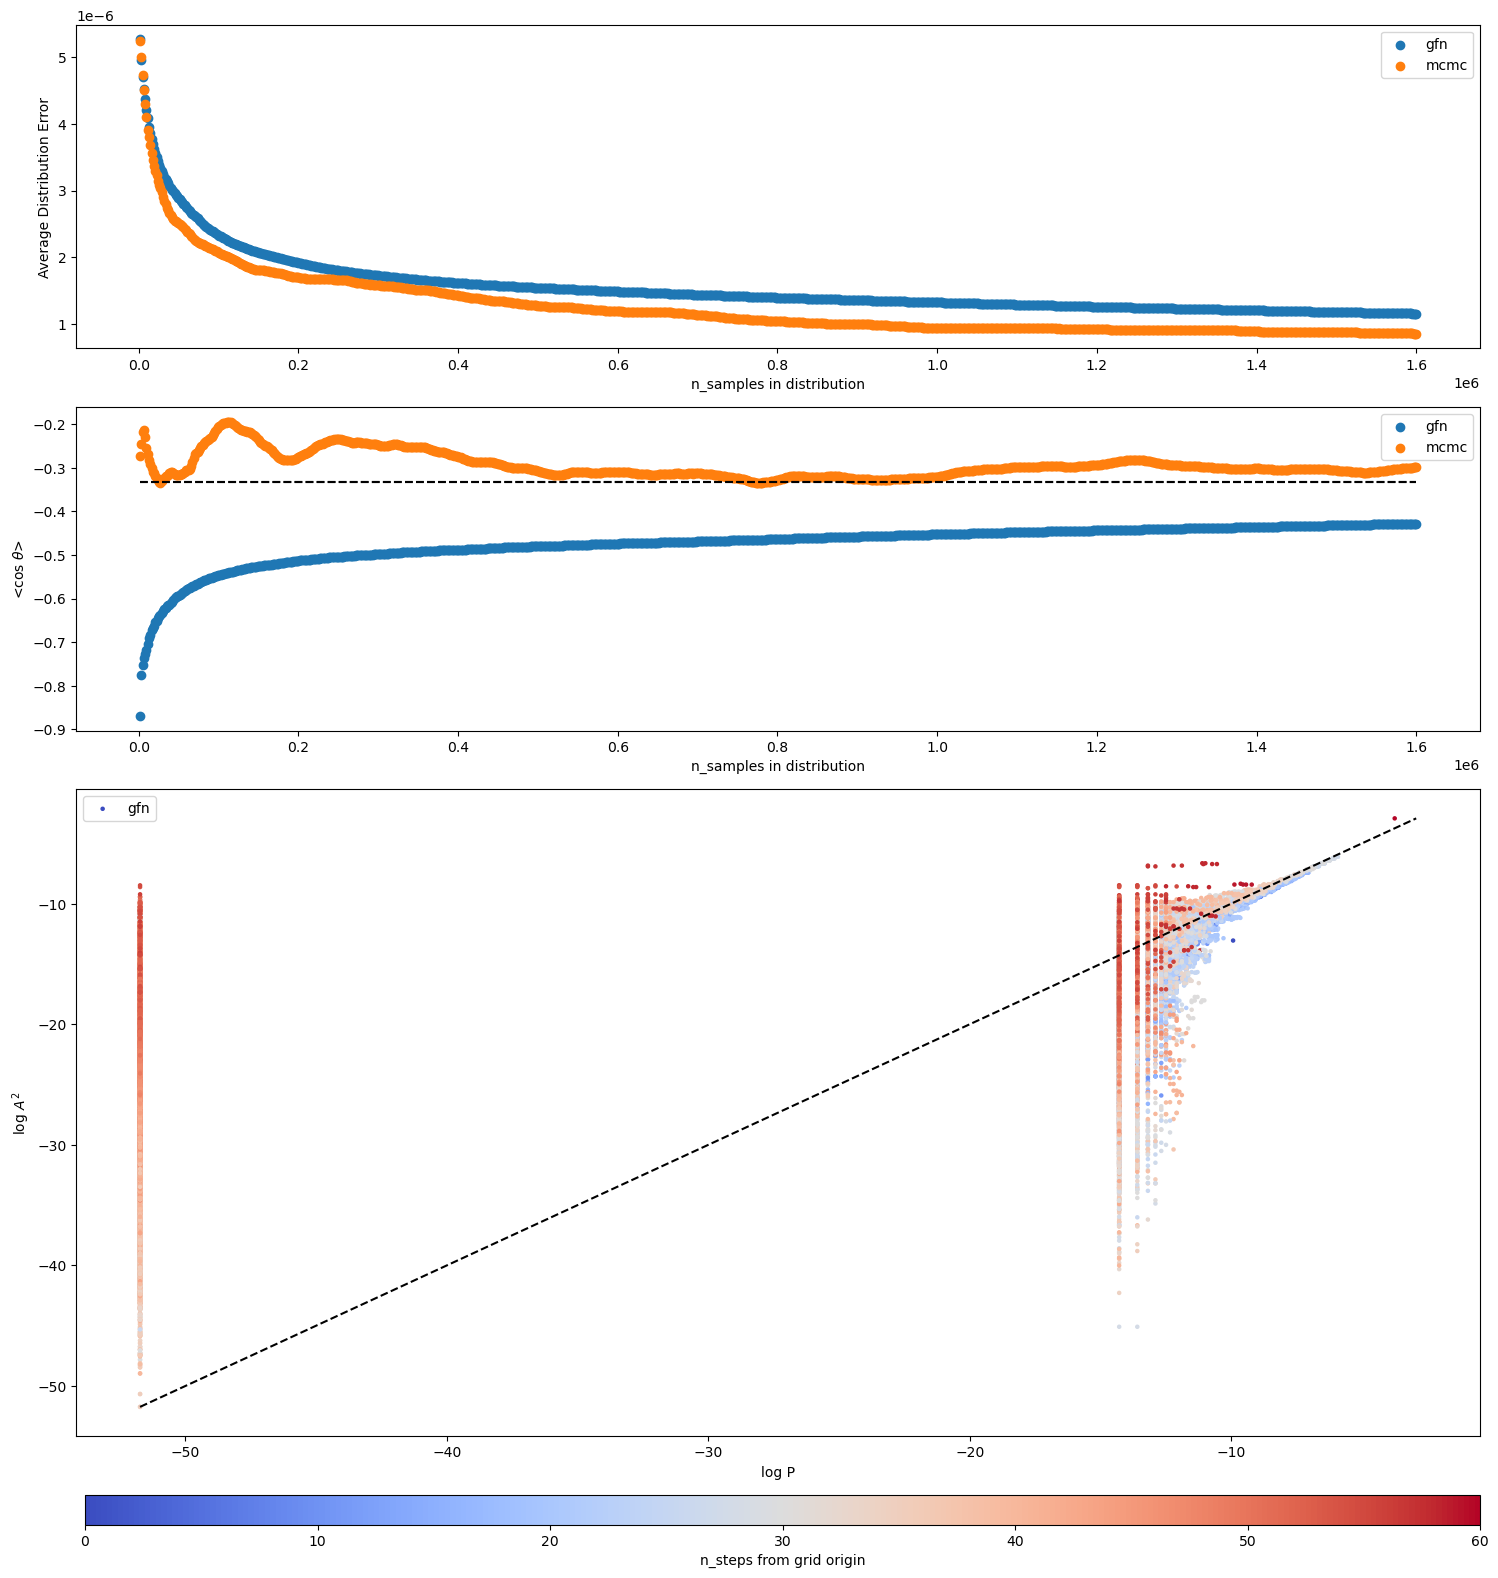

In [6]:
gfn_states = np.load(f"{ROOT_DIR}/data/GFN/single vertex spinfoam/j={float(spin_j)}/terminal_states.npy")
gfn_distributions_over_time, gfn_n_t = get_distributions_over_time(
    gfn_states, grid_len, every_n_iterations=100
)

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 15), gridspec_kw={'height_ratios': [1, 1, 2]})

plot_l1_errors(
    gfn_distributions_over_time, grid_rewards, gfn_n_t, ax[0], "gfn"
)
plot_l1_errors(
    mcmc_distributions_over_time, grid_rewards, mcmc_n_t, ax[0], "mcmc"
)

plot_observable_expectation_values(
    gfn_distributions_over_time, gfn_n_t, spin_j, ax[1], "gfn"
)
plot_observable_expectation_values(
    mcmc_distributions_over_time, mcmc_n_t, spin_j, ax[1], "mcmc"
)

i = -1
plot_log_empirical_vs_log_expected(
    gfn_distributions_over_time[i], grid_rewards, ax[2], "gfn"
)

plt.tight_layout()
cbar = fig.colorbar(ax[2].collections[0], cax=fig.add_axes([0.06, -0.02, 0.93, 0.02]), orientation="horizontal")
cbar.ax.set_xlabel("n_steps from grid origin");

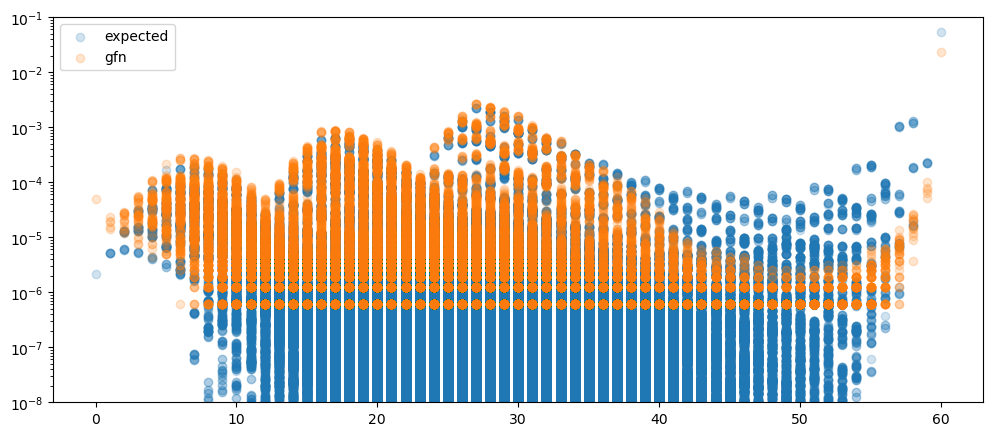

In [10]:
n_steps_from_origin = get_n_steps_from_grid_origin(grid_rewards)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 5))

ax.scatter(n_steps_from_origin, grid_rewards.ravel(), label="expected", alpha=0.2)
ax.scatter(n_steps_from_origin, gfn_distributions_over_time[-1].ravel(), label="gfn", alpha=0.2)
ax.set_yscale("log")
ax.set_ylim(1e-8, 0.1)
ax.legend()

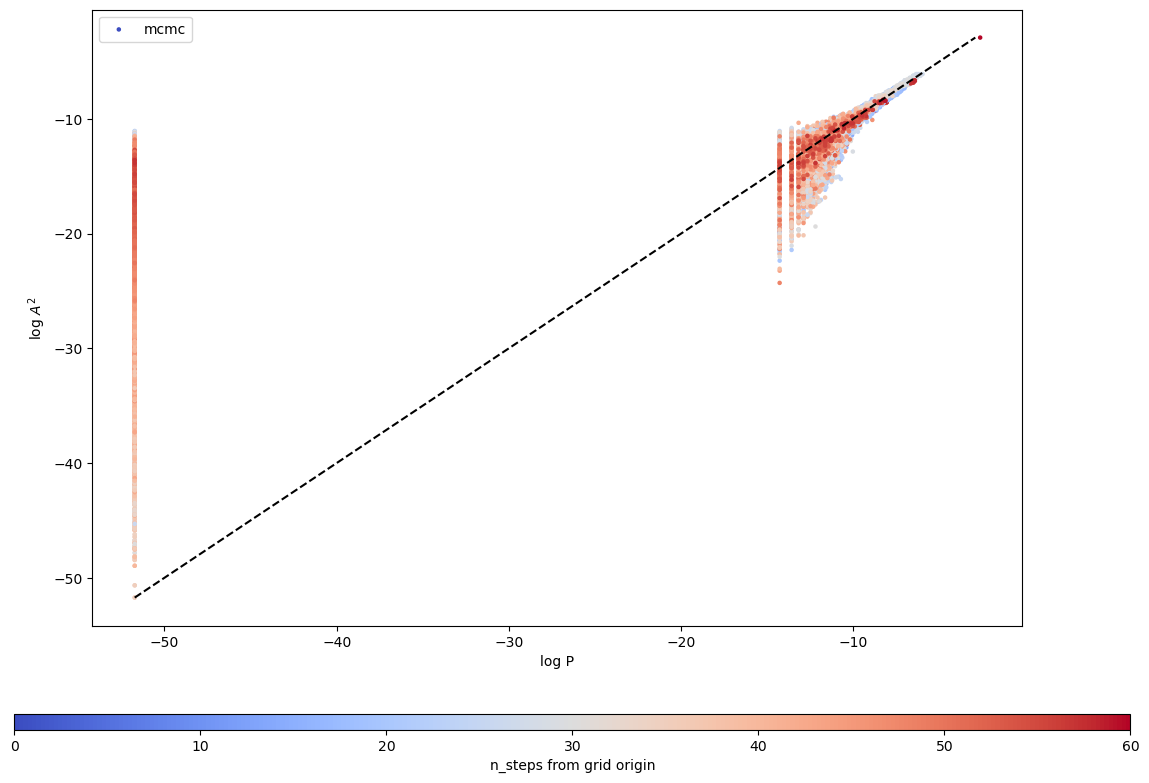

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

i = -1
plot_log_empirical_vs_log_expected(
    mcmc_distributions_over_time[i], grid_rewards, ax, "mcmc"
)

cbar = fig.colorbar(ax.collections[0], cax=fig.add_axes([0.06, -0.02, 0.93, 0.02]), orientation="horizontal")
cbar.ax.set_xlabel("n_steps from grid origin");


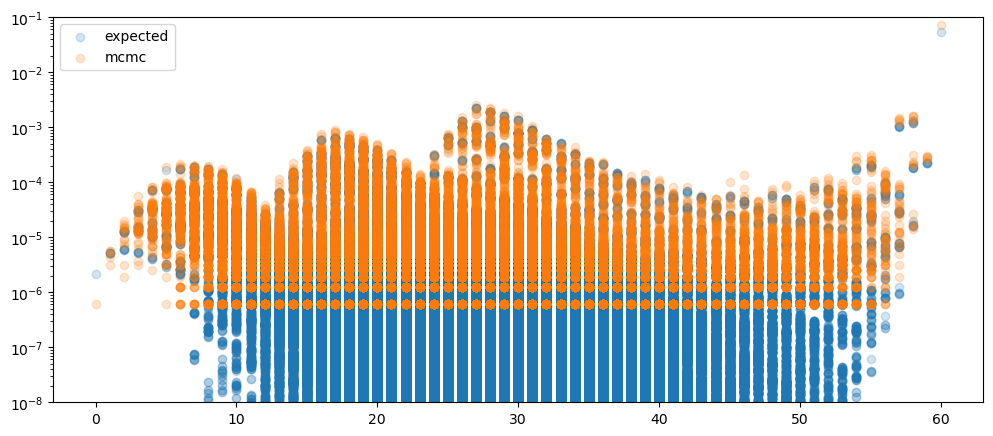

In [11]:
n_steps_from_origin = get_n_steps_from_grid_origin(grid_rewards)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 5))

ax.scatter(n_steps_from_origin, grid_rewards.ravel(), label="expected", alpha=0.2)
ax.scatter(n_steps_from_origin, mcmc_distributions_over_time[-1].ravel(), label="mcmc", alpha=0.2)
ax.set_yscale("log")
ax.set_ylim(1e-8, 0.1)
ax.legend()